# XΩ of Separation

This is the function on the server for downloading the required userdata:
```
@ApiMethod(name = "kevinBacon")
public Notice kevinBacon() {
    ArrayList<Profile> profiles = getAll(PROFILE);    // Get all users from database
    String result = getTimestamp() + ":";	         // Initialize result string with current date
    for (Profile p : profiles)                        // Append user's id and ids of all contacts (=following)
        result += p.getId().toString() + "." + p.getFollowing() + ";";
    return new Notice(result + ";");                  // Notice is just a wrapper class for String
}
```
The returned String looks like this:
```
timestamp:uid1.[uid11, uid12, uid13, ...];uid2.[uid21, uid22, uid23, ...];...;;
```
With `uidxy` being the user-id of the `y`-th person user `x` follows (contacts are also included in following, used synonymously from here on).

These strings are then concatenated in a file called `"data"` which then looks like this:
```
timestamp1:...;;timestamp2:...;;...
```

In [1]:
import random
from pprint import pprint
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from math import inf, nan

First things first: We need to read the data into our python program.

In [2]:
data = open("data").read()
entries = [x for x in data.split(";;") if x != ""]    # Divide data by date and remove empty entries
entry = entries[-1]                                   # The last entry, will be used here for demonstration

Because the entry is still just a string, it needs to be split up into an array containing all its data. To make some stuff a bit more digestable, we will also randomly pick 50 users to be used later for demonstrations.

In [3]:
def split_entry(entry):
    dt = entry.split(":")[0]    # The entry's timestamp
    users = {}                  # Users' contacts {uid1: [uid11, uid12, uid13, ...], uid2: [uid21, uid22, ...], ...}
    
    # Split entry into single users and save their ids and their contacts' ids into `users`.
    for user in entry.split(":")[1].split(";"):
        users[user.split(".")[0]] = [x for x in user.split(".")[1][1:-1].split(", ") if x != ""]
    
    return dt, users

In [4]:
dt, users = split_entry(entry)
uids = list(users.keys())
users_test = random.sample([u for u in users if users[u]], 10)    # Pick 50 random connected users for demonstration
users_test_idx = [uids.index(u) for u in users_test]              # Also save indices of `users_test`
pprint(dict(random.sample(users.items(), 1)))                     # Print 1 random sample from `users`

{'5709255063633920': ['5655638436741120',
                      '5120632077418496',
                      '5151365789646848',
                      '5759826290278400',
                      '5634387206995968',
                      '5683127032741888',
                      '5103873383464960',
                      '5680316245082112',
                      '5717424225648640',
                      '6299076077289472']}


To better understand the data, it is helpful to visualize the network. This is done here using a directed graph with the arrows pointing from a user to its contacts.

Network of ePotato users on 20171105141240:


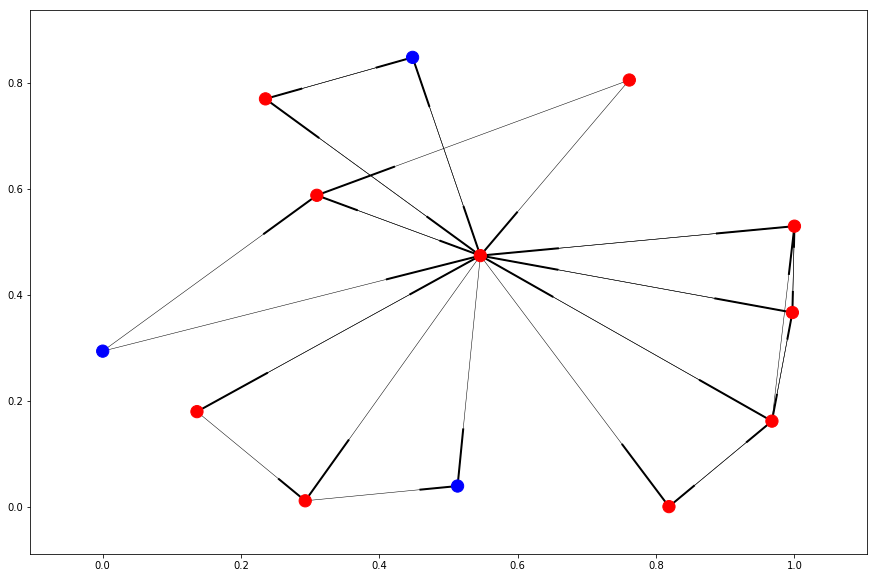

In [62]:
def visualize_network(network, special=set(), labels=False, small=False):
    G = nx.DiGraph()    # Directed Graph -> the thicker parts of lines are "arrow heads", {a: [b]} => (a -> b)
    
    for n in network.items():
        for c in n[1]:
            G.add_edge(n[0], c)    # Because only edges are added to `G`, isolated nodes (=users) won't be shown
    
    node_colors = ['r' if x in special else 'b' for x in G.nodes()]
    
    plt.rc('figure', figsize=((6, 4) if small else (15, 10)))
    nx.draw_networkx(G, with_labels=labels, node_color=node_colors, node_size=150, width=0.5)
    plt.show()

print("Network of ePotato users on %s:" % dt)
visualize_network(users, set(users_test))

That's it for data preprocessing, now for the fun part.

## Separation

The matix whose elements $s_{X\rightarrow Y}$ are the degrees of separation from user $X$ to user $Y$ is called the separation matrix. It is organized in the following fashion:

$$
S = 
\begin{bmatrix}
s_{A\rightarrow A} & s_{A\rightarrow B} & s_{A\rightarrow C} & \dots & s_{A\rightarrow N} \\
s_{B\rightarrow A} & s_{B\rightarrow B} & s_{B\rightarrow C} & \dots & s_{B\rightarrow N} \\
s_{C\rightarrow A} & s_{C\rightarrow B} & s_{C\rightarrow C} & \dots & s_{C\rightarrow N} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
s_{N\rightarrow A} & s_{N\rightarrow B} & s_{N\rightarrow C} & \dots & s_{N\rightarrow N}
\end{bmatrix}
$$

Note that this matrix will not be symmetrical when considering all contacts of a user (directed separation), because if $X$ follows $Y$, the separation  is 1°, but if $Y$ does not follow $X$, the separation $s_{Y\rightarrow X}$ is not 1°!

Because of this, it also follows that the separation matrix for the must be symmetrical when only considering mutual friends ('$X$ follows $Y$' $\Leftrightarrow$ '$Y$ follows $X$') because then $s_{X\rightarrow Y} = s_{Y\rightarrow X} = s_{X\leftrightarrow Y}$ (undirected separation).

The diagonal elements $s_{X\leftrightarrow X}$ of both matrices are equal to zero.

### Directed Separation

The separation matrix `S` will first be initialized to contain `inf` as every element, symbolizing an infinite separation.

For actually calculating the separations, we need to loop over all users (=nodes) of the network and take a look at their contacts (=`network[node]`) to build up that user's row in the matrix by setting up an array called `levels` with the first level being equal to the id of the current user (Separation = 0°)

Then for the next levels:
- Level 1 will contain the ids in `network[node]` (the contacts / outgoing connections) of the user, Separation = 1°
- Level 2 will contain the contacts of the users in `level[1]`, Separation = 2°
- Level 3 will contain the contacts of the users in `level[2]`, Separation = 3°
- ...

This will go on until no new users are in the last level's users' contacts. Finally, the current user's row in the separation matrix will be filled by assigning the number of the level the column's user is in to that column. This continues for every user until the the matrix is filled.

In [6]:
def separation(network):
    S = np.full((len(network), len(network)), inf)    # Initialize S to infinite separations
    nodes = list(network.keys())
    
    # Loop over all nodes, each time building up that node's row in the matrix.
    for node in network:
        levels = [[node]]    # Node X in levels[n] => Separation `node` -> user X: n°
        known = [node]       # Every node only has to be sorted into levels once (the lowest possible level)
        
        # Fill up `levels` until there are no new nodes to sort
        for level in levels:
            for node_ in level:
                for node__ in network[node_]:
                    if node__ not in known:
                        if level is levels[-1]:
                            levels.append([])
                        known.append(node__)
                        levels[-1].append(node__)
        
        # Write out level-numbers as columns in node's row in S
        for i in range(len(levels)):
            for node_ in levels[i]:
                S[nodes.index(node), nodes.index(node_)] = i
    
    return S

Directed Separation Matrix (Extract):

[[  0.   2.   2.  inf   2.   2.   2.   1.   2.   2.]
 [ inf   0.  inf  inf  inf  inf  inf  inf  inf  inf]
 [  2.   2.   0.  inf   2.   2.   1.   1.   1.   1.]
 [  1.   2.   2.   0.   2.   2.   2.   1.   2.   2.]
 [  2.   2.   2.  inf   0.   2.   2.   1.   2.   2.]
 [  2.   1.   2.  inf   2.   0.   2.   1.   2.   2.]
 [  2.   2.   1.  inf   2.   2.   0.   1.   2.   1.]
 [  1.   1.   1.  inf   1.   1.   1.   0.   1.   1.]
 [  3.   3.   1.  inf   3.   3.   2.   2.   0.   2.]
 [  2.   2.   2.  inf   2.   2.   1.   1.   2.   0.]]


Representation:


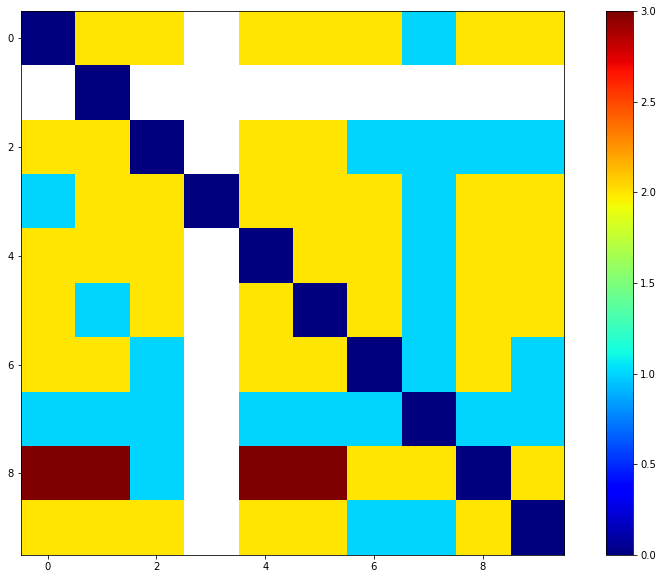

In [7]:
def visualize_matrix(mat):
    plt.rc('figure', figsize=(15.0, 10.0))
    plt.imshow(mat, cmap="jet")
    plt.colorbar()
    plt.show()

S = separation(users)[users_test_idx, :][:, users_test_idx]
print(f"Directed Separation Matrix (Extract):\n\n{S}\n\n\nRepresentation:")
visualize_matrix(S)

### Undirected Separation

To find the undirected seperation between two users, we must first remove all direction from the network. This is done using either one of two functions: `misdirect` or `loosen`. While `misdirect` removes all directed edges from the network, so that only "mutual friends" remain, `loosen` converts every edge into an undirected edge, so that the whole network is more closely connected.

In [8]:
def misdirect(network):
    # Remove all directed edges from network
    net = {k: [c for c in network[k] if c in network and k in network[c]] for k in network}
    return net

Undirected (Misdirected) Separation Matrix (Extract):

[[  0.  inf   2.  inf   2.   2.   2.   1.   3.   2.]
 [ inf   0.  inf  inf  inf  inf  inf  inf  inf  inf]
 [  2.  inf   0.  inf   2.   2.   1.   1.   1.   2.]
 [ inf  inf  inf   0.  inf  inf  inf  inf  inf  inf]
 [  2.  inf   2.  inf   0.   2.   2.   1.   3.   2.]
 [  2.  inf   2.  inf   2.   0.   2.   1.   3.   2.]
 [  2.  inf   1.  inf   2.   2.   0.   1.   2.   1.]
 [  1.  inf   1.  inf   1.   1.   1.   0.   2.   1.]
 [  3.  inf   1.  inf   3.   3.   2.   2.   0.   3.]
 [  2.  inf   2.  inf   2.   2.   1.   1.   3.   0.]]


Representation:


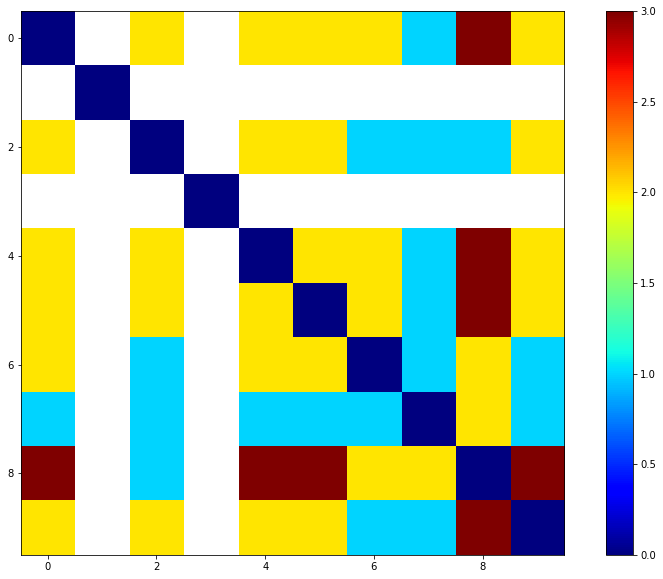

In [9]:
S = separation(misdirect(users))[users_test_idx, :][:, users_test_idx]
print(f"Undirected (Misdirected) Separation Matrix (Extract):\n\n{S}\n\n\nRepresentation:")
visualize_matrix(S)

In [10]:
def loosen(network):
    net = network.copy()
    for n, cs in list(net.items()):
        for c in cs:
            net[c] = list(set(net.get(c, [])) | {n})    # Add node to all connected nodes
    return net

Undirected (Loose) Separation Matrix (Extract):

[[ 0.  2.  2.  1.  2.  2.  2.  1.  2.  2.]
 [ 2.  0.  2.  2.  2.  1.  2.  1.  2.  2.]
 [ 2.  2.  0.  2.  2.  2.  1.  1.  1.  1.]
 [ 1.  2.  2.  0.  2.  2.  2.  1.  2.  2.]
 [ 2.  2.  2.  2.  0.  2.  2.  1.  2.  2.]
 [ 2.  1.  2.  2.  2.  0.  2.  1.  2.  2.]
 [ 2.  2.  1.  2.  2.  2.  0.  1.  2.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  0.  1.  1.]
 [ 2.  2.  1.  2.  2.  2.  2.  1.  0.  2.]
 [ 2.  2.  1.  2.  2.  2.  1.  1.  2.  0.]]


Representation:


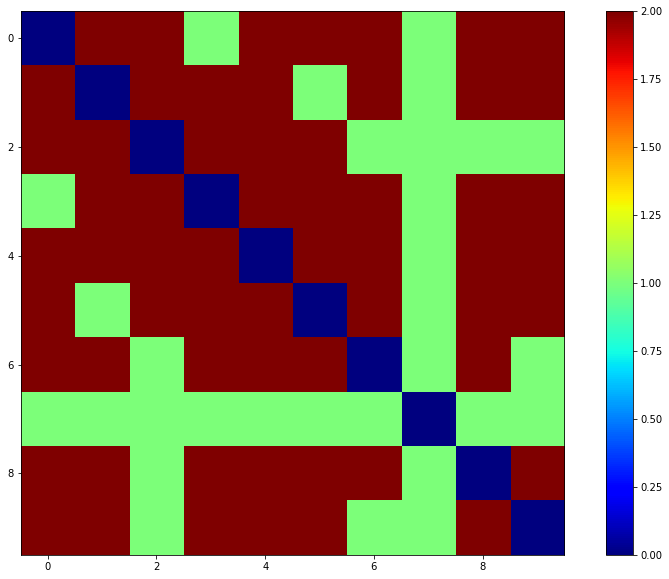

In [11]:
S = separation(loosen(users))[users_test_idx, :][:, users_test_idx]
print(f"Undirected (Loose) Separation Matrix (Extract):\n\n{S}\n\n\nRepresentation:")
visualize_matrix(S)

## Resistance Distance

The next step is to calculate the resistance between the users (=nodes). For this, every edge (=connection) in the network is assigned a resistance of 1 Ohm. To find out the resulting resistance between two individual users, the whole network has to be simplified to only one edge using the following techniques:
- Simplification
    - Series Circuits (3 nodes $\rightarrow$ 2 nodes)
    - Parallel Circuits (2 edges $\rightarrow$ 1 edge)
- Star-Mesh Transform ($n + 1$ nodes $\rightarrow$ $n$ nodes, $n$ edges $\rightarrow$ $\binom{n}{2}$ edges)

### Series Circuits

![](https://upload.wikimedia.org/wikipedia/commons/c/ce/Two_Resistors_in_series.svg)

The formula for calculating the resulting resistor of a series circuit of $n$ resistors is very simple:

$$
R = R_1 + R_2 + ... + R_n
$$

but because it is computationally simpler to just regard a series of two resistors at a time, we will only use the case where $n = 2$:

$$
R = R_1 + R_2
$$

### Parallel Circuits

![](https://upload.wikimedia.org/wikipedia/commons/a/a6/Two_Resistors_in_Parallel.svg)

The formula for calculating the resulting resistor of $n$ parallel resistors is also simple:

$$
\frac{1}{R} = \frac{1}{R_1} + \frac{1}{R_2} + ... + \frac{1}{R_n}
$$

again, because it is simpler, we will just use the case where $n$ = 2, so that

$$
R = \frac{R_1 · R_2}{R_1 + R_2}
$$

Because it is not possible for parallel connections to exist between two nodes, parallel circuits will only play a role after simplifying a series of edges to one edge. In a network of three nodes A, B and C, where A is connected to B and C and B also is connected to C, there are no parallel edges. If we however simplify the connection A - B - C to A - C by eliminating the middle node B, we need to consider the initial edge A - C as well. This is then done using the above formula to calculate the resulting resistor.

Because of this, both these forms of simplification are bundled in one function called `simplify`:

In [12]:
def simplify(network, resistors, a, b):
    net = network.copy()
    rs = resistors.copy()
    
    again = True
    while again:
        again = False      # Will be set to True if simplification was found
        active = {a, b}    # Active nodes: Those that are important for the resistance
        
        # Active nodes need to have incoming and outgoing connections.
        for ns in net.values():
            active |= {n for n in ns if n in net and net[n]}
        
        net_ = net.copy()    # Backup to check for changes
        
        # Remove all non-active nodes from the network
        net = {k: [c for c in net[k] if c in active and c != a] for k in active if k != b}
        rs = {k: rs[k] for k in rs if set(k) <= active and k[0] != b and k[1] != a}
        
        # Network has changed -> repeat from the top
        if net != net_:
            again = True
            continue
        
        # Loop over nodes with only one outgoing connection -> check for incoming connections
        for n, cs in [(n, cs) for n, cs in net.items() if len(cs) == 1 and n != a]:
            # Incoming nodes that are different from the outgoing node
            incoming = [x[0] for x in net.items() if n in x[1] and x[0] != cs[0]]

            # No incoming connections found -> delete semi-isolated node and repeat from the top
            if not incoming and n != b:
                del net[n]
                again = True
                break

            # One incoming connection -> redundand node, can be simplified as series connection
            if len(incoming) == 1:
                i = incoming[0]; o = cs[0]
                R = rs[i, n] + rs[n, o]    # Resulting resistor of series circuit

                # There is no existing edge -> Just simplify the series circuit, add new edge to network
                if (i, o) not in rs:
                    rs[i, o] = R
                    net[i].append(o)

                # There is an existing edge -> Simplify series and parallel circuits
                else:
                    rs[i, o] = R * rs[i, o] / (R + rs[i, o])

                # Delete redundand node from network and repeat from the top
                del net[n]
                again = True
                break
                    
    return net, rs

To supply the above function with a network of resistors, a function `build_resistors` will be defined, initializing every edge in a network to 1 Ohm:

In [15]:
def build_resistors(network):
    resistors = {}
    # Loop over edges, initialize every resistor to 1 Ohm
    for node in network.items():
        for node_ in node[1]:
            resistors[node[0], node_] = 1    # `resistors`: {(node1, node2): R}
    return resistors

### Star-Mesh Transform

![](https://upload.wikimedia.org/wikipedia/commons/2/29/Star-mesh_transform.svg)

Because only very simple networks can be simplified to a single edge using series and parallel circuits, we need to use another tool for simplifying the network, called Star-Mesh transform. It is a generalization of a technique called Y$\Delta$-transform and allows us to eliminate one node from a "star" by adding $\binom{n}{2} - n$ edges, $n$ being the number of edges in the initial star (so $n = 5$ in the picture). The value of these new resistors is given by the formula:

$$
R_{\nu\mu} = R_{\nu 0} R_{\mu 0} \sum_{k=1}^{n} \frac{1}{R_{k 0}}
$$

where $n$ is the number of edges of the star, 0 is the middle node of the star that is being eliminated and $R_{\nu\mu}$ is the resistor between nodes $\nu$ and $\mu$.

Because this technique does not work for directed connections (or maybe it does, I just couldn't figure out how), we first need to misdirect or loosen the network using the functions defined above before commencing the transformation. Because the resistors are also stored in a directed manner, those need to be undirected as well. This latter task is done using the function `undirect`.

As a result of this, true directed resistances can only be calculated if the network is so simple that star-mesh transform is no option. However, because `simplify` does compute directed resistances, we can calculate a semi-directed (from here on just "directed") resistance by first simplifying the directed network and the loosening it for star-mesh transformations.

In [13]:
def star_mesh_transform(network, resistors, a, b):
    net = network.copy()
    rs = resistors.copy()
    
    # `n0`: Middle node of star, `cs`: Edges of star
    n0, cs = next((n0, cs) for n0, cs in net.items() if n0 not in {a, b})
    Rs = {}
    
    # Calculate new resistors and reconnect network
    for n in list(cs):
        for m in [c for c in cs if c != n]:
            # Calculate R_nm with star-mesh formula
            R = rs[n, n0] * rs[m, n0] * sum([1 / R for R in [R for k, R in rs.items() if k[0] == n0]])

            # Add new edge (double-sided)
            net[n] = list(set(net.get(n, [])) | {m})
            net[m] = list(set(net.get(m, [])) | {n})

            # Condense resistors
            rs[n, m] = rs[m, n] = R * rs[n, m] / (R + rs[n, m]) if (n, m) in rs else R

        # Remove star-edges
        net[n].remove(n0)
        net[n0].remove(n)

    # Remove old resistors
    rs = undirect(rs, net)
        
    return net, rs

In [14]:
def undirect(resistors, network):
    rs = {}
    # Add all resistors (double-sided) of which the edges are found in the network
    for k, R in [(k, R) for k, R in list(resistors.items()) if k[1] in network[k[0]]]:
        rs[k[0], k[1]] = rs[k[1], k[0]] = R
    return rs

Now that all important functions for calculating the resistance between two nodes in a network are defined, we can create a single function for the computation called `resistance`. This function will loop over the functions `simplify` and `star_mesh_transform` until the network cannot be simplified any more and, if the network was simplified to one edge, return the resulting resistor:

In [67]:
def resistance(network, a, b, resistors=None, iterations=False, visualize=False):
    # Check if a = b
    if a == b:
        return (0, 0) if iterations else 0
    
    net = network.copy()
    
    # If resistors are not predefined, initialize them all to 1 Ohm (directed)
    if not resistors:
        rs = build_resistors(network)
    else:
        rs = resistors.copy()
    
    net_ = net.copy()    # Backup to check for changes
    i = 0                # Iterations counter
    
    while True:
        # Simplification
        net, rs = simplify(net, rs, a, b)
        
        if visualize:
            print("Simplification (Directed):")
            visualize_network(net, {a, b}, small=True, labels=True)
        
        # No changes or single connection: finished
        if net == net_ or set(net.keys()) <= {a, b}:
            break
            
        net_ = net.copy()    # Backup to check for changes
        
        # Star-Mesh Transform
        net = loosen(net)
        rs = undirect(rs, net)
        net, rs = star_mesh_transform(net, rs, a, b)
        
        i += 1
            
        if visualize:
            print(f"Star-Mesh Transform (Loosened Network) #{i}:")
            visualize_network(net, {a, b}, small=True, labels=True)
    
    R = nan    # Initialize R to NaN for when it can not be computed using star-mesh transform and simplification
    if len(rs) == 1:
        R = list(rs.values())[0]
    elif len(rs) == 0:
        R = inf
    
    return (R, i) if iterations else R

As an example, take a look at the following (small) network and its simplification to one edge:

Network to be analyzed:


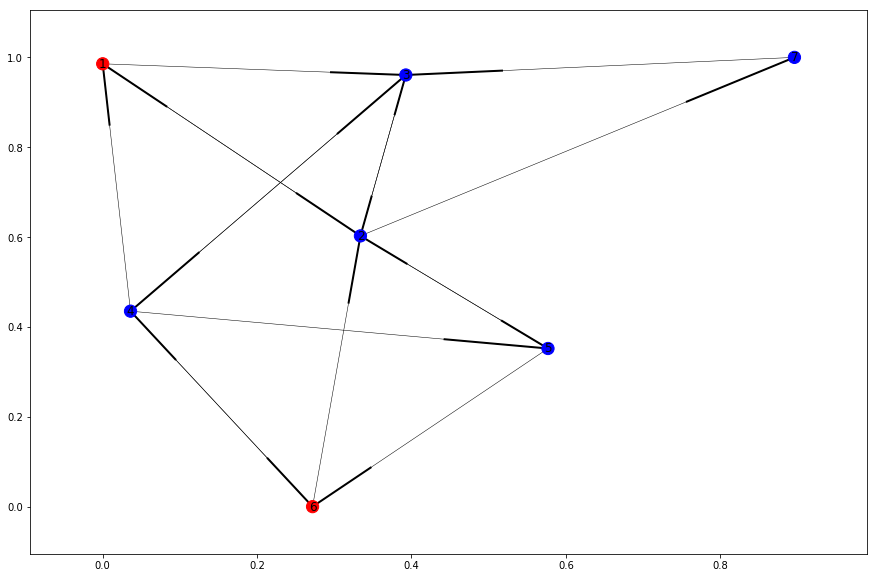

Simplification (Directed):


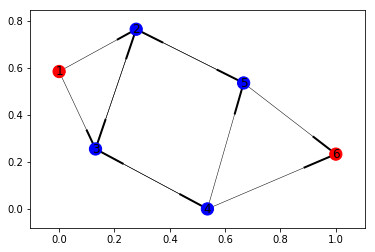

Star-Mesh Transform (Loosened Network) #1:


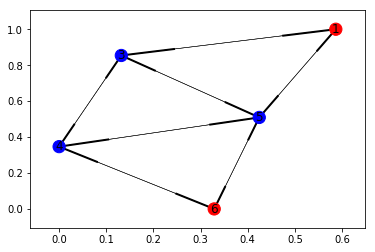

Simplification (Directed):


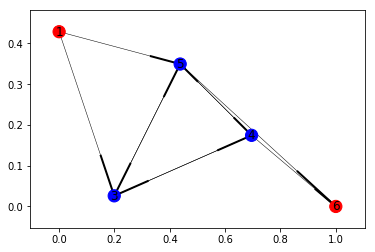

Star-Mesh Transform (Loosened Network) #2:


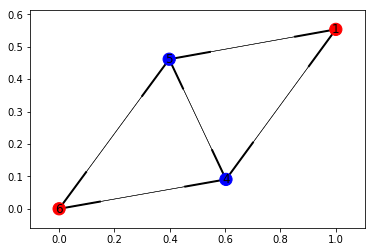

Simplification (Directed):


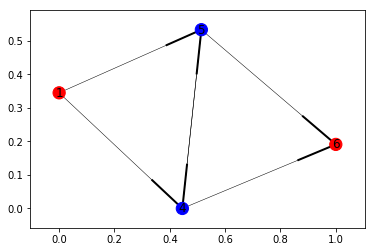

Star-Mesh Transform (Loosened Network) #3:


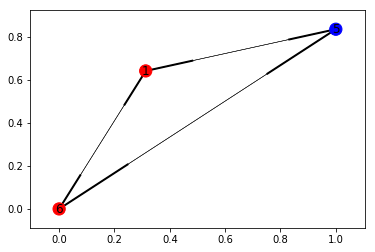

Simplification (Directed):


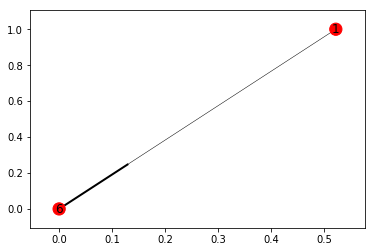

R = 1.500000Ω (3 iterations) <- Directed Resistance 1 -> 6
R = 1.000000Ω (2 iterations) <- Directed Resistance 6 -> 1
R = 4.000000Ω (0 iterations) <- Misdirected Resistance
R = 0.743750Ω (4 iterations) <- Loosened Resistance


In [88]:
net = {1: [2, 3], 2: [3, 1, 5, 7], 3: [4, 2], 4: [3, 1, 5, 6], 5: [2, 6], 6: [2, 4], 7: [3]}
a = 1; b = 6

print("Network to be analyzed:")
visualize_network(net, {a, b}, labels=True)

print("R = %8.6fΩ (%d iterations) <- Directed Resistance 1 -> 6" % resistance(net, a, b, iterations=True, visualize=True))
print("R = %8.6fΩ (%d iterations) <- Directed Resistance 6 -> 1" % resistance(net, b, a, iterations=True))
print("R = %8.6fΩ (%d iterations) <- Misdirected Resistance" % resistance(misdirect(net), a, b, iterations=True))
print("R = %8.6fΩ (%d iterations) <- Loosened Resistance" % resistance(loosen(net), a, b, iterations=True))

### Resistance Distance Matrix

Now we can create a resistance distance matrix $R$, similar to the separation matrix $S$:

$$
R = 
\begin{bmatrix}
R_{A\rightarrow A} & R_{A\rightarrow B} & R_{A\rightarrow C} & \dots & R_{A\rightarrow N} \\
R_{B\rightarrow A} & R_{B\rightarrow B} & R_{B\rightarrow C} & \dots & R_{B\rightarrow N} \\
R_{C\rightarrow A} & R_{C\rightarrow B} & R_{C\rightarrow C} & \dots & R_{C\rightarrow N} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
R_{N\rightarrow A} & R_{N\rightarrow B} & R_{N\rightarrow C} & \dots & R_{N\rightarrow N}
\end{bmatrix}
$$

with the following function:

In [74]:
def resistance_distance(network):
    R = np.empty((len(network), len(network)))    # No intialization necessary, `resistance` always returns a value
    nodes = list(network.keys())
    
    for a in network:
        for b in network:
            R[nodes.index(a), nodes.index(b)] = resistance(network, a, b)
                
    return R

Resistance Distance Matrix (Extract):

[[ 0.          1.66666667  1.47619048         inf  1.66666667  2.          1.475
   1.          1.6         1.475     ]
 [        inf  0.                 inf         inf         inf         inf
          inf         inf         inf         inf]
 [ 1.5         1.16666667  0.                 inf  1.16666667  1.5         0.5
   0.5         0.6         0.5       ]
 [ 0.66666667  1.33333333  1.14285714  0.          1.33333333  1.66666667
   1.14166667  0.66666667  1.26666667  1.14166667]
 [ 1.66666667  1.33333333  1.14285714         inf  0.          1.66666667
   1.14166667  0.66666667  1.26666667  1.14166667]
 [ 2.          0.66666667  1.47619048         inf  1.66666667  0.          1.475
   1.          1.6         1.475     ]
 [ 1.475       1.14166667  0.57142857         inf  1.14166667  1.475       0.
   0.5         0.875       0.5       ]
 [ 1.          0.66666667  0.47619048         inf  0.66666667  1.          0.475
   0.          0.6         0.4

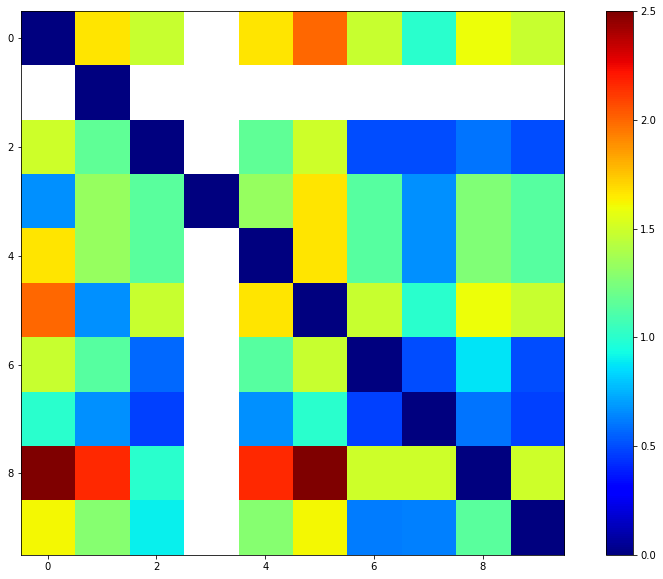

In [70]:
R = resistance_distance(users)[users_test_idx, :][:, users_test_idx]
print(f"Resistance Distance Matrix (Directed, Extract):\n\n{R}\n\n\nRepresentation:")
visualize_matrix(R)

Resistance Distance Matrix (Misdirected, Extract):

[[ 0.                 inf  1.625              inf  1.66666667  2.          1.5
   1.          2.625       1.625     ]
 [        inf  0.                 inf         inf         inf         inf
          inf         inf         inf         inf]
 [ 1.625              inf  0.                 inf  1.29166667  1.625       0.625
   0.625       1.          1.        ]
 [        inf         inf         inf  0.                 inf         inf
          inf         inf         inf         inf]
 [ 1.66666667         inf  1.29166667         inf  0.          1.66666667
   1.16666667  0.66666667  2.29166667  1.29166667]
 [ 2.                 inf  1.625              inf  1.66666667  0.          1.5
   1.          2.625       1.625     ]
 [ 1.5                inf  0.625              inf  1.16666667  1.5         0.
   0.5         1.625       0.625     ]
 [ 1.                 inf  0.625              inf  0.66666667  1.          0.5
   0.          1.625 

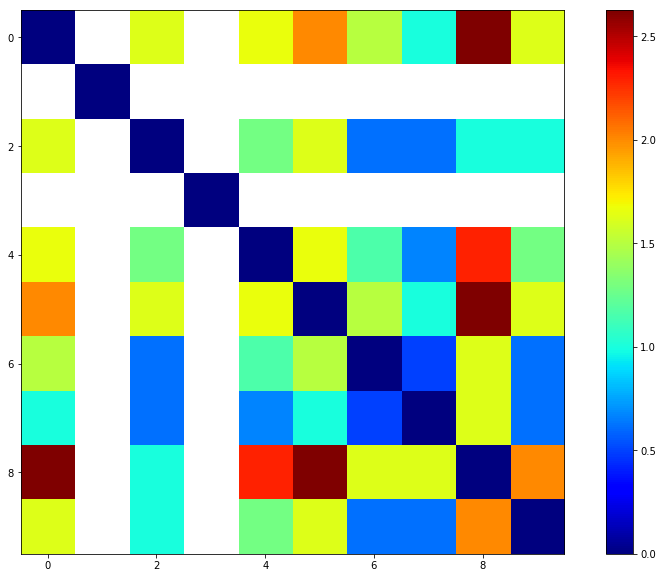

In [73]:
R = resistance_distance(misdirect(users))[users_test_idx, :][:, users_test_idx]
print(f"Resistance Distance Matrix (Misdirected, Extract):\n\n{R}\n\n\nRepresentation:")
visualize_matrix(R)

Resistance Distance Matrix (Loose, Extract):

[[ 0.          1.          0.9         0.625       1.16666667  1.125       0.975
   0.5         1.1         0.975     ]
 [ 1.          0.          0.9         1.125       1.16666667  0.625       0.975
   0.5         1.1         0.975     ]
 [ 0.9         0.9         0.          1.025       1.06666667  1.025       0.475
   0.4         0.6         0.475     ]
 [ 0.625       1.125       1.025       0.          1.29166667  1.25        1.1
   0.625       1.225       1.1       ]
 [ 1.16666667  1.16666667  1.06666667  1.29166667  0.          1.29166667
   1.14166667  0.66666667  1.26666667  1.14166667]
 [ 1.125       0.625       1.025       1.25        1.29166667  0.          1.1
   0.625       1.225       1.1       ]
 [ 0.975       0.975       0.475       1.1         1.14166667  1.1         0.
   0.475       0.875       0.5       ]
 [ 0.5         0.5         0.4         0.625       0.66666667  0.625       0.475
   0.          0.6         0.475   

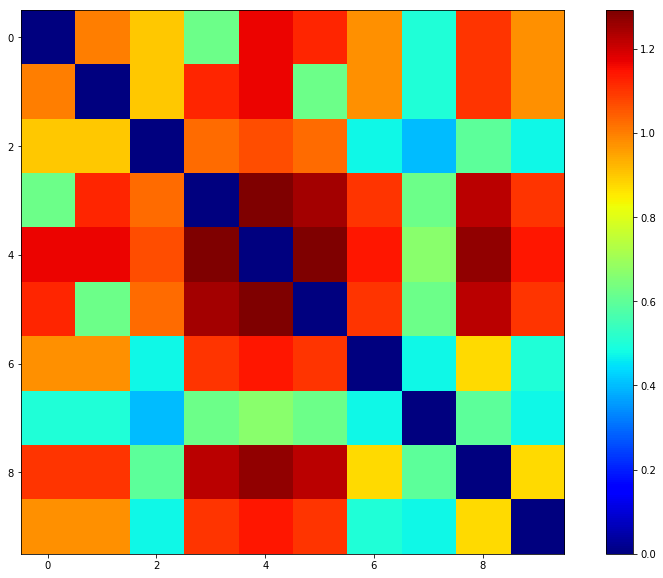

In [72]:
R = resistance_distance(loosen(users))[users_test_idx, :][:, users_test_idx]
print(f"Resistance Distance Matrix (Loose, Extract):\n\n{R}\n\n\nRepresentation:")
visualize_matrix(R)

## Whole Network Analysis

In [18]:
def propagate(network, a):
    net = {a: network[a]}
    history = set()
    cache = set(network[a])
    while cache:
        for node in set(cache):
            net[node] = list(set(net.get(node, []) + network[node]))
            for node_ in net[node]:
                net[node_] = list(set(net.get(node_, [])) | {node})
            cache |= {n for n in net[node] if n not in history}
            history.add(node)
            cache.remove(node)
    return net